# Import the necessary libraries

In [4]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import os
import cv2# computer vision & image preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import array_to_img
import keras_ocr
import easyocr# for detection of text
import pytesseract#for detection of text

# Approach


<img style="transform: rotate(90deg); width:1000px" src="image1.jpg" alt="sieve shaker" title="Title text" />

# Data Preprocessing

1. As the dataset of the car images with the number plates, collected from the **RoboFlow universe**,then uploaded to **Kaggle** for use of online GPU, its co-ordinates are normalized, so to get the proper size of the rectangular bounding boxes, we multiply them with **224 x 224** pixel size.

2. After that we convert the image into greyscale format.

3. After that around this bounding box, we created a **binary mask** of around the bounding box to extract the number plate from the images.

4. A **Laplacian filter** is applied to the grayscale image to detect edges, followed by thresholding to truncate values above a certain threshold (215), resulting in a binary image. Basically smoothing the image.This filter is used to remove noise from the image,and is also ensures the text preservance in the images.

5. The thresholded image is converted back to BGR format and normalized.

In [4]:
def preprocess_data(image_dir, label_dir, target_size=(224, 224)):
    images = []
    labels = []
    mask_img=[]
    n=0
    for img_file in os.listdir(image_dir):
        if n <500:
            n+=1
        else :
            break
        if img_file.endswith(('.bmp', '.jpg', '.jpeg')):
            label_file = img_file.split('.')[0] + '.txt'
            label_path = os.path.join(label_dir, label_file)
            with open(label_path, 'r') as f:
                label_data = f.readline().strip().split()  # Read bounding box coordinates
                c,x, y, w, h = map(float, label_data)
                x= x*224
                y= y*224
                w= w*224
                h = h*224
                x= x-w/2
                y = y-h/2
            start = (int(x),int(y))
            end = (int(x+w),int(y+h))
            
            img_path = os.path.join(image_dir, img_file)
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, target_size)
            gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
            
            mask = np.zeros((224,224), dtype=np.uint8)
            cv2.rectangle(mask, start, end, 255, thickness=cv2.FILLED)
           
            imi = cv2.bitwise_and(mask,gray)
            imi = imi/255
            mask_img.append(imi)
            
           
            laplacian = cv2.Laplacian(gray, cv2.CV_8U)  
            laplacian_abs = np.uint8(np.absolute(laplacian))

            _, b = cv2.threshold(laplacian_abs,215, 255,cv2.THRESH_TRUNC)
            
            g = cv2.cvtColor(b, cv2.COLOR_GRAY2BGR)
            image =g/ 255.0
           

           
            images.append(image)
            labels.append([x, y, w, h])

    return np.array(images), np.array(labels),np.array(mask_img)


# Model Building

1. Now we have the data with proper labels, we can start with the model building.
2. We are going to use ResNet152 ,as a pretrained model,for the object detection task,as it has skip connections which is going to help us in preventing overfitting and faster training.
3. For finding optimal hyperparameters, we are going to use a random search approach.

**Hyperparameter Tuning**

It has been commented ,as it is going to take lot of time.

In [ ]:
# from kerastuner.tuners import RandomSearch

# tuner = RandomSearch(
#     ResNet152(),
#     objective='val_accuracy',
#     max_trials=20,  # Number of different hyperparameter combinations to try
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='resnet152_tuning'
# )
# tuner.search(train_data, train_labels, epochs=50, validation_data=(val_data, val_labels), batch_size=32)


In [3]:
def create_resnet152_model(input_shape=(224, 224, 3)):
  
    base_model = ResNet152(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False 
    for layer in base_model.layers[-10:]:
        layer.trainable = True 

    model = models.Sequential([
        base_model,
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),  # Convolution to process features
        layers.BatchNormalization(),
        layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu'),  # Upsampling
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),  # Upsampling
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),  # Upsampling
        layers.BatchNormalization(),
        layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),  # Upsampling
        layers.BatchNormalization(),
        layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu'),  # Upsampling
        layers.BatchNormalization(),
        layers.Conv2D(1, (2,2), padding='same', activation='sigmoid'),  # Final output layer for 3 channels
    ])
    return model


In [31]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152 (Functional)          │ (None, 7, 7, 2048)     │    58,370,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 512)      │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 14, 14, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_23             │ (None, 56, 56, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 112, 112, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 3)    │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,379,907 (264.66 MB)

 Trainable params: 15,472,643 (59.02 MB)

 Non-trainable params: 53,907,264 (205.64 MB)

# Evaluation Metrics

We are going to use IOU loss as our loss function, as it is widely used in object detection.IOU is defined as the area of the intersection over the area of the union of two bounding boxes.

In [18]:
# Define input shape
input_shape = (224, 224, 3)
model = create_resnet152_model(input_shape)
def iou_metric(y_true, y_pred):
    # Convert to binary masks if necessary
    y_true = tf.cast(y_true > 0, tf.float32)
    y_pred = tf.cast(y_pred > 0, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)  # Area of overlap
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection  # Area of union
    
    # Avoid division by zero
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou
def iou_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)  # Area of overlap
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection  # Area of union

    # Avoid division by zero
    iou = intersection / (union + tf.keras.backend.epsilon())
    
    return 1 - iou
# Compile the model
model.compile(optimizer='adam', loss=iou_loss, metrics=[iou_metric])


# Prepare the dataset
image_dir = '/kaggle/input/new-best-far/train/images'
label_dir ="/kaggle/input/new-best-far/train/labels"

# Preprocess the data
X, Y ,z= preprocess_data(image_dir, label_dir)
z = np.expand_dims(z, axis=-1) 
print(z.shape)




(500, 224, 224, 1)


# Model Training

In [19]:
history=model.fit(X, z, batch_size=32, epochs=80, validation_split=0.2)

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - iou_metric: 0.0140 - loss: 0.9925 - val_iou_metric: 0.0139 - val_loss: 0.9935
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - iou_metric: 0.0143 - loss: 0.9873 - val_iou_metric: 0.0139 - val_loss: 0.9933
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - iou_metric: 0.0145 - loss: 0.9845 - val_iou_metric: 0.0139 - val_loss: 0.9923
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 338ms/step - iou_metric: 0.0142 - loss: 0.9825 - val_iou_metric: 0.0139 - val_loss: 0.9944
Epoch 5/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - iou_metric: 0.0142 - loss: 0.9805 - val_iou_metric: 0.0139 - val_loss: 0.9956
Epoch 6/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - iou_metric: 0.0146 - loss: 0.9762 - val_iou_metric: 0.0139 - val_loss: 0.9976
Epoch 7/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - iou_metric: 0.0138 - loss: 0.9751 - val_iou_metric: 0.0139 - val_loss: 0.9969
Epoch 8/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - iou_metric: 0.0140 - los

# Results Visualization

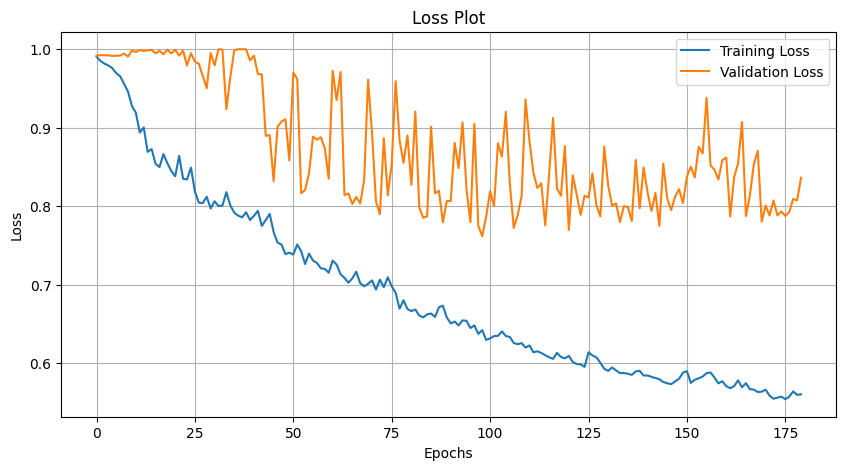

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

*Now as we are seeing ,that there is overfitting in the model. This is the best model after trying lots of combinations. The most probably reason is that CNN focuses more  on the local features of the image than the global features, it is not going to process the entire image in one go.*

# Testing of the Plate detection model

In [22]:
def predict_bounding_box(model, image_path, target_size=(224, 224)):
    image_original = cv2.imread(image_path)
    image_r = cv2.resize(image_original, target_size)
    gray = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_8U)  # Use CV_64F to retain negative values
    laplacian_abs = np.uint8(np.absolute(laplacian))

    _,b= cv2.threshold(laplacian_abs,215, 255,cv2.THRESH_TRUNC)
    
    g = cv2.cvtColor(b, cv2.COLOR_GRAY2BGR)
    image_normalized =g/ 255.0
    image_batch = np.expand_dims(image_normalized, axis=0)  # Add batch dimension
    prediction = model.predict(image_batch)
    t= prediction[0]
    t = (t * 255).astype(np.uint8)

    _, binary = cv2.threshold(t, 240, 255, cv2.THRESH_BINARY)
    white_pixels = np.where(binary == 255)

    y_min, y_max = np.min(white_pixels[0]), np.max(white_pixels[0]) 
    x_min, x_max = np.min(white_pixels[1]), np.max(white_pixels[1]) 

    coordinates= [x_min,y_min,x_max,y_max]
    return coordinates





# EasyOCR for Plate Recognition

Now we are going to use the `EasyOCR` for the text of the plate recognition. Its first identify the clusters of the pixels which are going to form to characters. Then, it will segment these regions into the words for proper recgnition.

In [6]:
#!pip install easyocr
reader = easyocr.Reader(['en'])  

In [319]:
def text_detection(coordinates, image_path):
    pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
    image= cv2.imread(image_path)
    gray2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(224,224))
    gray2 = cv2.resize(gray2,(224,224))
    extracted_texts = {}
    
    x, y,X, Y = coordinates
    x-=20
    y-=10
    X+=12
    Y+=12
    roi = image[y:Y,x:X]
    

    mask = np.zeros(gray2.shape, dtype=np.uint8)
    
    cv2.rectangle(mask, (x, y), (X, Y), 255, -1)

    masked_image = cv2.bitwise_and(gray2,gray2, mask=mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    bottom_hat = cv2.morphologyEx(masked_image, cv2.MORPH_BLACKHAT, kernel)
    results = reader.readtext(bottom_hat)

# Extract and print detected text
    detected_text = [text for (_, text, _) in results]
    (text_width, text_height), baseline = cv2.getTextSize(detected_text[0], cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)



    cv2.rectangle(image, (x, y - text_height - baseline-10), (x + text_width, y-10 + baseline), (0, 255, 0), thickness=cv2.FILLED)
    cv2.putText(image, detected_text[0], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.4,(0,0,255), 1)


    cv2.rectangle(image,(x,y),(X,Y), (0,255,0),2)
    
    plt.imshow(image)
    plt.show()
    
    
    return detected_text



# Testing of the OCR and Plate Detection model

/kaggle/input/new-far3/p3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


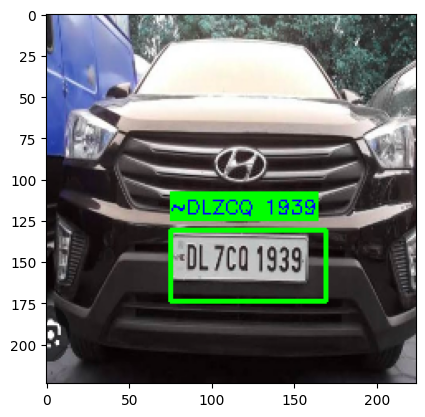

['~DLZCQ 1939']
/kaggle/input/new-far3/p2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


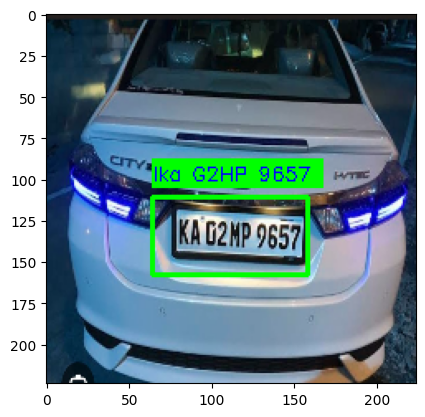

['Ika G2HP 9657 ']
/kaggle/input/new-far3/p1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


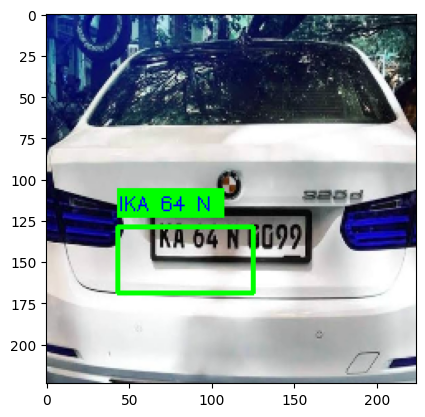

['IKA 64 N ']
/kaggle/input/new-far/new_far/img/53.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


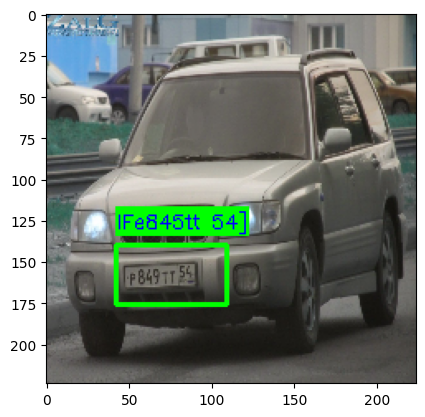

['IFe845tt 54]']


In [323]:
image_path=['/kaggle/input/new-far3/p3.jpg','/kaggle/input/new-far3/p2.jpg','/kaggle/input/new-far3/p1.jpg','/kaggle/input/new-far/new_far/img/53.jpg',]
for i in image_path:
    print(i)
    cor= predict_bounding_box(model,i)
    text= text_detection(cor,i)
    print(text)

From the above output images we can see that our model is doing good, though for some noisy characters, it is unable to detect them or unable to recognize them correctly.